<a target="_blank" href="https://colab.research.google.com/github/markusmeister/MIB-R/blob/markus-dev47/python/Ch_1_Figures.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Ch 1 - Elements of Calculus
This notebook contains python code for generating figures in Chapter 1 of the book _Mathematics in Biology_.

## Imports and utilities

In [ ]:
import numpy as np
from pathlib import Path
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

# set font to be used in figures
import matplotlib.font_manager as font_manager
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'serif';
cmfont = font_manager.FontProperties(fname=matplotlib.get_data_path() + '/fonts/ttf/cmr10.ttf');
matplotlib.rcParams['font.serif']=cmfont.get_name();
matplotlib.rcParams['axes.formatter.use_mathtext'] = True
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams['font.size'] = 11

# set path to save the figures
Save = False # change if you are saving figures to a local drive
if Save:
  # set path to save the figures
  savedir = Path('../img')
  savedir.mkdir(parents=True, exist_ok=True)

In [ ]:
# Utilities for plotting

def plot(X, Y=None, xlabel=None, ylabel=None, legend=[], loc=None, title=None, alpha=1.0,
         xlim=None, ylim=None, xscale='linear', yscale='linear',
         xticks=None, yticks=None, xhide=False, yhide=False, yrot=False,
         xzero=False, yzero=False, yflip=False,
         fmts=['r-','g-','b-','y-','c-','m-'], linewidth=2, markersize=5, fillstyle='full',
         markeredgewidth=1, rasterized=False,
         grid=False, equal=False, figsize=(5,3), axes=None):
    """
    Plot data points.
    X: an array or list of arrays
    Y: an array or list of arrays
    If Y exists then those values are plotted vs the X values
    If Y doesn't exist the X values are plotted
    xlabel, ylabel: axis labels
    legend: list of labels for each Y series
    loc: location of the legend, like 'upper right'
    title: duh
    xlim, ylim: [low,high] list of limits for the 2 axes
    xscale, yscale: 'linear' or 'log'
    xticks, yticks: list of locations for tick marks, or None for auto ticks
    yhide: hide the y axis?
    yrot: rotate the yaxis label to horizontal?
    yzero: zero line for the y-axis?
    fmts: a list of format strings to be applied to successive Y-series
    linewidth, markersize, fillstyle, markeredgewidth: see docs
    grid: draw a grid?
    equal: use equal aspect ratio, i.e. same scale per unit on x and y axis?
    figsize: (h,v) in inches
    rasterized: rasterize the data portion of the graph?
    axes: pre-existing axes where to draw the plot
    Returns: axes for the plot
    """

    if not axes: # start a new figure
        fig = plt.figure(figsize=figsize)
        axes = plt.gca()

    def has_one_axis(X): # Return True if X (ndarray or list) has 1 axis
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    # axes.cla() # clears these axes
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt, linewidth=linewidth, markersize=markersize,
            	fillstyle=fillstyle,markeredgewidth=markeredgewidth,
            	rasterized=rasterized, alpha=alpha)
        else:
            axes.plot(y, fmt, linewidth=linewidth, markersize=markersize,
            	fillstyle=fillstyle,markeredgewidth=markeredgewidth,
            	rasterized=rasterized, alpha=alpha)
    set_axes(axes, xlabel, ylabel, legend, loc, xlim, ylim, xscale, yscale,
             xticks, yticks, xhide, yhide, yrot, xzero, yzero, yflip, grid, equal)
    if title:
        plt.title(title)
    plt.tight_layout()

    return axes # useful if we started a new figure

def hist(X, bins=50, range=None, density=None, weights=None, histtype='stepfilled', stacked=False,
         align='mid', color=['r','g','b','m'], alpha=0.5, linewidth=1,
         xlabel=None, ylabel=None, legend=[], loc=None, title=None,
         xlim=None, ylim=None, xscale='linear', yscale='linear',
         xticks=None, yticks=None, xhide=False, yhide=False, yrot=False,
         xzero=False, yzero=False, yflip=False,
         grid=False, figsize=(5,3), axes=None, orientation='vertical'):
    """
    Histogram data.
    X: an array or list of arrays to be histogrammed
    bins: the number of bins, or a list of edges
    range: [low,high] the range over which the bins are spread
    density: normalize to unit area?
    weights: array same shape as X; each value in X only contributes that weight.
    histtype: 'bar','barstacked','step','stepfilled'
    stacked: plot multiple series on top of each other?
    align: 'left','mid',right', center the bar on left edge, center, or right edge of bin
    color: list of colors for the data series
    alpha: opacity, useful if histtype='stepfilled'
    xlabel, ylabel: axis labels
    legend: list of labels for each Y series
    loc: location of the legend, like 'upper right'
    title: duh
    xlim, ylim: [low,high] list of limits for the 2 axes
    xscale, yscale: 'linear' or 'log'
    xticks, yticks: list of locations for tick marks, or None for auto ticks
    yhide: hide the y axis?
    yrot: rotate the yaxis label to horizontal?
    yzero: zero line for the y-axis?
    grid: draw a grid?
    figsize: (h,v) in inches
    axes: pre-existing axes where to draw the plot
    Returns: axes, n, bins, patches
    """

    if not axes: # start a new figure
        fig,ax = plt.subplots(figsize=figsize)
    else:
    	ax=axes

    def has_one_axis(X): # Return True if X (ndarray or list) has 1 axis
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        ndata=1
    else:
        ndata=len(X) # assuming it is an ndarray or a list of lists

    if len(color)<ndata: # if there aren't enough dolors provided
        col=None # use the default color sequence
    else:
        col=color[:ndata]

    if histtype=='step' or histtype=='stepfilled': # in these cases the legend sequence needs to be inverted for some reason
        if isinstance(legend, list):
        	legend = legend[-1::-1]

    n, bins, patches = ax.hist(X, bins=bins, range=range, density=density, weights=weights,
                                 histtype=histtype, stacked=stacked, align=align,
                                 color=col, alpha=alpha, linewidth=linewidth,
                                 label=legend, orientation=orientation)

    set_axes(ax, xlabel, ylabel, legend, loc, xlim, ylim, xscale, yscale,
    	xticks, yticks, xhide, yhide, yrot, xzero, yzero, yflip, grid, equal=False)

    if title:
        plt.title(title)
    if not axes:
    	plt.tight_layout() # otherwise let the caller take care of layout

    return ax, n, bins, patches # useful if we started a new figure

def set_axes(axes, xlabel, ylabel, legend, loc, xlim, ylim, xscale, yscale,
    	xticks, yticks, xhide, yhide, yrot, xzero, yzero, yflip, grid, equal):
    """Set the axes for matplotlib."""
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    if xlim:
        axes.set_xlim(xlim)
    else:
        axes.set_xlim(auto=True)
    if ylim:
        axes.set_ylim(ylim)
    else:
        axes.set_ylim(auto=True)
    if grid:
        axes.grid()
    if equal:
        axes.set_aspect(aspect='equal')
    if ylabel:
        if yrot:
            axes.set_ylabel(ylabel, fontsize=12, rotation=0, labelpad=15)
        else:
            axes.set_ylabel(ylabel, fontsize=12)
    if xlabel:
        axes.set_xlabel(xlabel, fontsize=12)
    axes.get_yaxis().set_visible(not yhide)
    axes.get_xaxis().set_visible(not xhide)
    if xzero:
        axes.axvline(color='black', linewidth=0.5)
    if yzero:
        axes.axhline(color='black', linewidth=0.5)
    if yflip:
        axes.invert_yaxis()
    axes.tick_params(axis = 'both', which = 'major', labelsize = 10)
    axes.tick_params(axis = 'both', which = 'minor', labelsize = 9)
    if xticks != None:
        axes.set_xticks(xticks); # no minor ticks
    if yticks != None:
        axes.set_yticks(yticks); # no minor ticks
    if legend:
        axes.legend(legend, loc=loc)
    plt.draw()
    #     To change the font and control the fontsize, can use some of these commands:
    #     axes.set_xlabel(xlabel, fontname='Arial', fontsize = 12)
    #     axes.set_ylabel(ylabel, fontname='Arial', fontsize = 12)
    #     axes.tick_params(axis = 'both', which = 'major', labelsize = 10)
    #     axes.tick_params(axis = 'both', which = 'minor', labelsize = 9)
    #     plt.yticks(fontname = "Arial")
    #     plt.xticks(fontname = "Arial")
    #     if legend:
    #         axes.legend(legend, prop={"size":12, "family":'Arial'})
    #     For options on legend placement see https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot

def test_plot():
    x = np.arange(-10,10,.01)
    t = [0.1,0.3,1,3,10]
    y = [np.exp(-x**2/(4*ti))/np.sqrt(4*np.pi*ti) for ti in t]
    plot (x,y,fmts=['r-','g-','b-','y-','c-','m-'],linewidth=1,
        xlabel='Distance',ylabel='Concentration',yzero=True,
        legend=['t=0.1','0.3','1','3','10'],xticks=[-10,-5,-1,0,1,5,10])

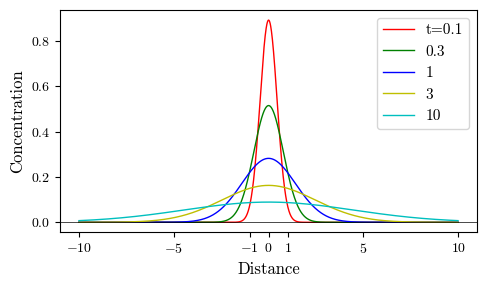

In [ ]:
test_plot()

## Elementary functions

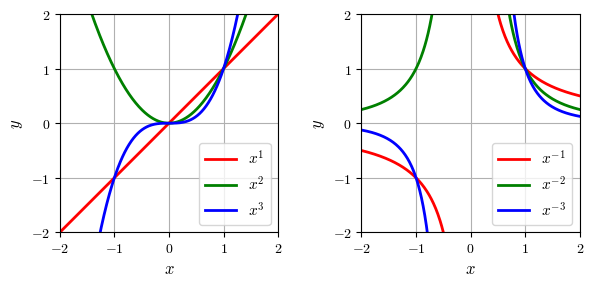

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(7,3))
x=np.arange(-2, 2.0, 0.01)
y=[x**1,x**2,x**3]
plot(x,y,fmts=['r-','g-','b-'],figsize=(4,3),
    legend=[r'$x^{1}$',r'$x^{2}$',r'$x^{3}$'],
    xlabel=r'$x$',
    ylabel=r'$y$',
    xlim=[-2,2],
    ylim=[-2,2],
    xticks=[-2,-1,0,1,2],
    yticks=[-2,-1,0,1,2],
    grid=True,
    equal=True,
    axes=ax[0]
);
x1=np.arange(-2, 0, 0.01)
x2=np.arange(0.01, 2.01, 0.01)
y1=[x1**-1,x1**-2,x1**-3]
y2=[x2**-1,x2**-2,x2**-3]
plot(x1,y1,fmts=['r-','g-','b-'],figsize=(4,3), axes=ax[1]);
plot(x2,y2,fmts=['r-','g-','b-'],figsize=(4,3),
    legend=[r'$x^{-1}$',r'$x^{-2}$',r'$x^{-3}$'],
    xlabel=r'$x$',
    ylabel=r'$y$',
    xlim=[-2,2],
    ylim=[-2,2],
    xticks=[-2,-1,0,1,2],
    yticks=[-2,-1,0,1,2],
    grid=True,
    equal=True,
    axes=ax[1]
);
fig.tight_layout();

if Save:
    fig.savefig(str(savedir / 'power_functions.pdf'), dpi=600, format='pdf', bbox_inches='tight');

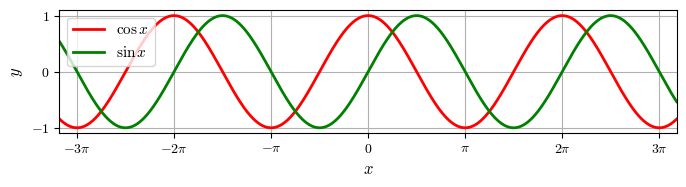

In [ ]:
x=np.arange(-10, 10.0, 0.01)
y=[np.cos(x),np.sin(x)]
fig, ax = plt.subplots(figsize=(7,2))
plot(x,y,fmts=['r-','g-'],
     legend=['$\cos x$','$\sin x$'],
     xlabel='$x$',
     ylabel='$y$',
     grid=True,
     xlim=[-10,10],
     axes=ax);

ax.set_xticks((np.pi*np.arange(-3,4)).tolist())
ax.set_xticklabels([r"$-3\pi$", r"$-2\pi$", r"$-\pi$", r"$0$",
                    r"$\pi$", r"$2\pi$", r"$3\pi$"])
fig.tight_layout()

if Save:
    fig.savefig(str(savedir / 'sinusoids.pdf'), dpi=600, format='pdf', bbox_inches='tight');

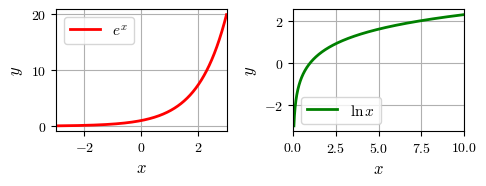

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(5,2))
x=np.arange(-3, 3.0, 0.01)
y=np.exp(x)
plot(x,y,fmts=['r-'],figsize=(4,3),
     legend=['$e^x$'],
     xlabel='$x$',
     ylabel='$y$',
     grid=True,
     xlim=[-3,3],
     axes=ax[0]
);
x=np.arange(0.05, 10, 0.01)
y=np.log(x)
plot(x,y,fmts=['g-'],figsize=(4,3),
     legend=['$\ln x$'],
     xlabel='$x$',
     ylabel='$y$',
     grid=True,
     xlim=[0,10],
     axes=ax[1]
);
fig.tight_layout()

if Save:
    fig.savefig(str(savedir / 'logarithms.pdf'), dpi=600, format='pdf', bbox_inches='tight');

## Differentiation

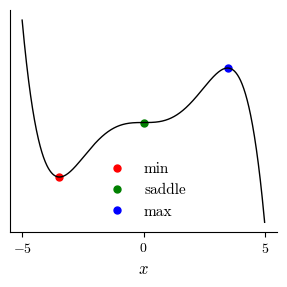

In [ ]:
a=-0.05
def f(x):
    return x**3+a*x**5
x=np.arange(-5, 5.0, 0.01)
xm=np.sqrt(-3/5/a)
u=np.array([-xm,0,xm])

fig,ax=plt.subplots(figsize=(3,3))
plot([[-xm],[0],[xm]],[[f(-xm)],[f(0)],[f(xm)]],
     fmts=['ro','go','bo'],
     markersize=5,
     legend=['min','saddle','max'],
     xlabel='$x$',
     axes=ax
);
plot(x,f(x),
     fmts=['k-'],
     linewidth=1,
     yhide=True,
     xlim=[-5.5,5.5],
     xticks=[-5,0,5],
     axes=ax
);
ax.legend_.set_frame_on(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()

if Save:
    fig.savefig(str(savedir / 'minima_maxima.pdf'), dpi=600, format='pdf', bbox_inches='tight');

## Integration

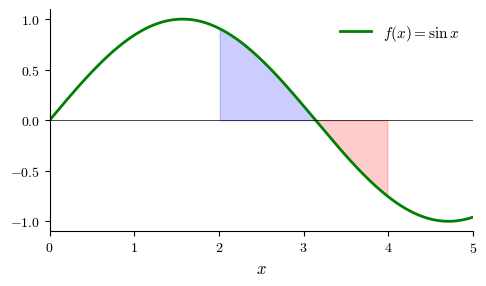

In [ ]:
# Area under the curve
def f(x):
    return np.sin(x)
x=np.arange(0, 5.0, 0.01)
fig,ax=plt.subplots(figsize=(5,3))
plot(x,f(x),yzero=True,xlabel='$x$',legend=['$f(x)=\sin x$'],xlim=[0,5], fmts=['g-'], axes=ax);
ax.fill_between(x, f(x), where=np.logical_and(x>2,x<np.pi), color='blue',alpha=0.2);
ax.fill_between(x, f(x), where=np.logical_and(x>np.pi,x<4), color='red',alpha=0.2);
ax.legend_.set_frame_on(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
if Save:
    fig.savefig(str(savedir / 'area_curve.pdf'), dpi=600, format='pdf', bbox_inches='tight');

## Multiple variables

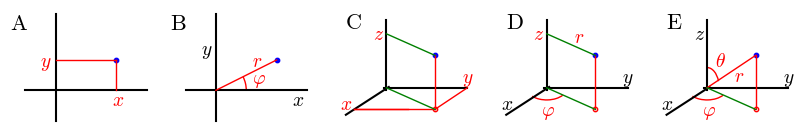

In [ ]:
from matplotlib.patches import Arc
import math

fig,ax=plt.subplots(1,5,figsize=(10,2))

ax[0].plot([-1,3],[0,0],'k')
ax[0].plot([0,0],[-1,2.5],'k')
ax[0].scatter(2,1,10,edgecolors='b',facecolors='b')
ax[0].plot([2,2],[0,1],'r',linewidth=1)
ax[0].plot([0,2],[1,1],'r',linewidth=1)
ax[0].text(1.85,-0.5 ,r'$x$',fontsize=14,color='r')
ax[0].text(-0.5,0.8 ,r'$y$',fontsize=14,color='r')
ax[0].text(-1.5,2 ,r'A',fontsize=16,color='k')

ax[0].axis('off')
ax[0].xlim=(-1,3)
ax[0].ylim=(-1,2)
ax[0].set_aspect('equal')

ax[1].plot([-1,3],[0,0],'k')
ax[1].plot([0,0],[-1,2.5],'k')
ax[1].scatter(2,1,10,edgecolors='b',facecolors='b')
ax[1].plot([0,2],[0,1],'r',linewidth=1)
ax[1].text(1.2,0.8 ,r'$r$',fontsize=14,color='r')
ax[1].text(1.2,0.25 ,r'$\varphi$',fontsize=14,color='r')
ax[1].text(-1.5,2 ,r'B',fontsize=16,color='k')
ax[1].text(2.5,-0.5 ,r'$x$',fontsize=14,color='k')
ax[1].text(-0.5,1.2 ,r'$y$',fontsize=14,color='k')
ax[1].add_patch(Arc((0,0), 2, 2, angle=0.0, theta1=0, theta2=180*math.atan(1/2)/np.pi,edgecolor='r'))

ax[1].axis('off')
ax[1].xlim=(-1,3)
ax[1].ylim=(-1,2)
ax[1].set_aspect('equal')

ax[4].plot([-0.1,3],[0,0],'k')
ax[4].plot([0,0],[-0.1,2.5],'k')
ax[4].plot([-1.5,0.09],[-1,0.03],'k')
ax[4].plot([0,1.8],[0,1.2],'r',linewidth=1)
ax[4].plot([1.8,1.8],[-0.8,1.2],'r',linewidth=1)
ax[4].plot([0,1.8],[0,-0.8],'g',linewidth=1)
ax[4].text(-1.5,2.2 ,r'E',fontsize=16,color='k')
ax[4].text(2.8,0.2 ,r'$y$',fontsize=14,color='k')
ax[4].text(-0.5,1.8 ,r'$z$',fontsize=14,color='k')
ax[4].text(-1.7,-0.8 ,r'$x$',fontsize=14,color='k')
ax[4].scatter(1.8,-0.8,10,edgecolors='r',facecolors='w')
ax[4].scatter(1.8,1.2,10,edgecolors='b',facecolors='b')

ax[4].text(1,0.25 ,r'$r$',fontsize=14,color='r')
ax[4].text(0.3,0.8 ,r'$\theta$',fontsize=14,color='r')
ax[4].text(-0.2,-1.0 ,r'$\varphi$',fontsize=14,color='r')
ax[4].add_patch(Arc((0,0), 1.5, 0.9, angle=0.0, theta1=-150, theta2=-25,edgecolor='r'))
ax[4].add_patch(Arc((0,0), 0.9, 1.5, angle=0.0, theta1=30, theta2=90,edgecolor='r'))

ax[4].axis('off')
ax[4].xlim=(-1,3)
ax[4].ylim=(-1,2)
ax[4].set_aspect('equal')

ax[2].plot([-0.1,3],[0,0],'k')
ax[2].plot([0,0],[-0.1,2.5],'k')
ax[2].plot([-1.5,0.09],[-1,0.03],'k')
ax[2].plot([-1.2,1.8],[-0.8,-0.8],'r',linewidth=1)
ax[2].plot([1.8,3],[-0.8,0],'r',linewidth=1)
ax[2].plot([1.8,1.8],[-0.8,1.2],'r',linewidth=1)
ax[2].plot([-1.2,0.8],[-0.8,-0.8],'r',linewidth=1)
ax[2].plot([0,1.8],[0,-0.8],'g',linewidth=1)
ax[2].plot([0,1.8],[2,1.2],'g',linewidth=1)
ax[2].text(-1.5,2.2 ,r'C',fontsize=16,color='k')
ax[2].text(2.8,0.2 ,r'$y$',fontsize=14,color='r')
ax[2].text(-0.5,1.8 ,r'$z$',fontsize=14,color='r')
ax[2].text(-1.7,-0.8 ,r'$x$',fontsize=14,color='r')
ax[2].scatter(1.8,-0.8,10,edgecolors='r',facecolors='w')
ax[2].scatter(1.8,1.2,10,edgecolors='b',facecolors='b')

ax[2].axis('off')
ax[2].xlim=(-1,3)
ax[2].ylim=(-1,2)
ax[2].set_aspect('equal')

ax[3].plot([-0.1,3],[0,0],'k')
ax[3].plot([0,0],[-0.1,2.5],'k')
ax[3].plot([-1.5,0.09],[-1,0.03],'k')
ax[3].plot([1.8,1.8],[-0.8,1.2],'r',linewidth=1)
ax[3].plot([0,1.8],[0,-0.8],'g',linewidth=1)
ax[3].plot([0,1.8],[2,1.2],'g',linewidth=1)
ax[3].text(-1.5,2.2 ,r'D',fontsize=16,color='k')
ax[3].text(2.8,0.2 ,r'$y$',fontsize=14,color='k')
ax[3].text(-0.5,1.8 ,r'$z$',fontsize=14,color='r')
ax[3].text(-1.7,-0.8 ,r'$x$',fontsize=14,color='k')
ax[3].scatter(1.8,-0.8,10,edgecolors='r',facecolors='w')
ax[3].scatter(1.8,1.2,10,edgecolors='b',facecolors='b')

ax[3].text(1,1.7 ,r'$r$',fontsize=14,color='r')
ax[3].text(-0.2,-1.0 ,r'$\varphi$',fontsize=14,color='r')
ax[3].add_patch(Arc((0,0), 1.5, 0.9, angle=0.0, theta1=-150, theta2=-25,edgecolor='r'))
ax[3].xlim=(-1,3)
ax[3].ylim=(-1,2)
ax[3].set_aspect('equal')
ax[3].axis('off')

if Save:
    fig.savefig(str(savedir / 'ch_Pre_coordinates.pdf'), dpi=600, format='pdf', bbox_inches='tight');

## Complex numbers

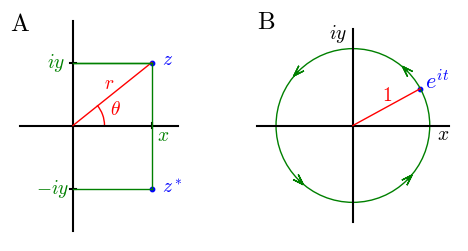

In [ ]:
from matplotlib.patches import Circle
from matplotlib.patches import Arc

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,3))

ax[1].plot([-2,2],[0,0],'k')
ax[1].plot([0,0],[-2,2],'k')
ax[1].plot([0,1.6*np.cos(0.5)],[0,1.6*np.sin(0.5)],'r',linewidth=1)
ax[1].scatter(1.6*np.cos(0.5),1.6*np.sin(0.5),10,edgecolors='b',facecolors='b')

ax[1].text(0.6,0.5 ,r'$1$',fontsize=14,color='r')
ax[1].text(1.75,-0.3 ,r'$x$',fontsize=14,color='k')
ax[1].text(-0.5,1.8 ,r'$iy$',fontsize=14,color='k')
ax[1].text(-2,2 ,r'B',fontsize=18,color='k')
ax[1].text(1.6*np.cos(0.5)+0.1,1.6*np.sin(0.5) ,r'$e^{it}$',fontsize=16,color='b')

ax[1].add_patch(Circle((0, 0),1.6,edgecolor='g',fill=False))
ax[1].arrow(1.6*np.cos(np.pi/4),1.6*np.sin(np.pi/4),-0.1,0.1,width=0.001,length_includes_head=True,head_width=0.15,
                overhang=1,color='g')
ax[1].arrow(1.6*np.cos(3*np.pi/4),1.6*np.sin(3*np.pi/4),-0.1,-0.1,width=0.001,length_includes_head=True,head_width=0.15,
                overhang=1,color='g')
ax[1].arrow(1.6*np.cos(5*np.pi/4),1.6*np.sin(5*np.pi/4),0.1,-0.1,width=0.001,length_includes_head=True,head_width=0.15,
                overhang=1,color='g')
ax[1].arrow(1.6*np.cos(7*np.pi/4),1.6*np.sin(7*np.pi/4),0.1,0.1,width=0.001,length_includes_head=True,head_width=0.15,
                overhang=1,color='g')

ax[1].axis('off')
ax[1].xlim=(-1,3)
ax[1].ylim=(-1,2)
ax[1].set_aspect('equal')

ax[0].plot([-1,2],[0,0],'k')
ax[0].plot([0,0],[-2,2],'k')


ax[0].text(1.6,-0.3 ,r'$x$',fontsize=14,color='g')
ax[0].text(-0.5,1.1 ,r'$iy$',fontsize=14,color='g')
ax[0].text(-0.7,-1.3 ,r'$-iy$',fontsize=14,color='g')
ax[0].text(-1.2,1.8 ,r'A',fontsize=18,color='k')
ax[0].text(1.7,1.15 ,r'$z$',fontsize=14,color='b')
ax[0].text(1.7,-1.3 ,r'$z^\ast$',fontsize=14,color='b')

ax[0].plot([0,1.5],[0,1.2],'r',linewidth=1)
ax[0].text(0.6,0.7 ,r'$r$',fontsize=14,color='r')
ax[0].text(0.7,0.2 ,r'$\theta$',fontsize=14,color='r')
ax[0].plot([0,1.5],[1.2,1.2],'g',linewidth=1)
ax[0].add_patch(Arc((0,0), 1.2, 1.2, angle=0.0, theta1=0, theta2=40,edgecolor='r'))

ax[0].plot([1.5,1.5],[-0.05,0.05],'k')
ax[0].plot([-0.05,0.05],[1.2,1.2],'k')
ax[0].plot([-0.05,0.05],[-1.2,-1.2],'k')
ax[0].plot([1.5,1.5],[-1.2,1.2],'g',linewidth=1)
ax[0].plot([0,1.5],[1.2,1.2],'g',linewidth=1)
ax[0].plot([0,1.5],[-1.2,-1.2],'g',linewidth=1)
ax[0].scatter(1.5,1.2,10,edgecolors='b',facecolors='b')
ax[0].scatter(1.5,-1.2,10,edgecolors='b',facecolors='b')

ax[0].axis('off')
ax[0].xlim=(-1,3)
ax[0].ylim=(-1,2)
ax[0].set_aspect('equal')

if Save:
    fig.savefig(str(savedir / 'ch_Pre_ComplexNumbers.pdf'), dpi=600, format='pdf', bbox_inches='tight');

## The delta function

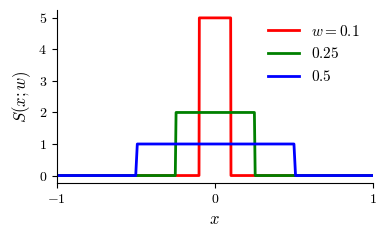

In [ ]:
x=np.arange(-5, 5.01, 0.01)
y=1*(np.abs(x)<0.5)
fig,ax=plt.subplots(figsize=(4,2.5))
legend = ['$w=0.1$','$0.25$','$0.5$'];
plot([x/5,x/2,x],[5*y,2*y,y],
     fmts=['r-','g-','b-'],
     legend=['$w=0.1$','$0.25$','$0.5$'],
     xlim=[-1,1],
     xticks=[-1,0,1],
     xlabel='$x$',
     ylabel='$S(x;w)$',
     axes=ax
);
ax.legend_.set_frame_on(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
if Save:
    fig.savefig(str(savedir / 'delta_pulse.pdf'), dpi=600, format='pdf', bbox_inches='tight');